## Import Libraries

In [7]:
import numpy as np
import pandas as pd
import os
import time
import datetime
import requests
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Gathering Data

#### a. Twitter Archive Enhanced

In [8]:
df_twitter_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

In [9]:
df_twitter_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### b. Image Prediction 

In [10]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [11]:
open('image_prediction.tsv', 'wb').write(response.content)

335079

In [12]:
df_predictions = pd.read_csv('image_prediction.tsv', sep='\t')
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### c. Query the Twitter API

In [6]:
consumer_key = 'hidden'
consumer_secret = 'hidden'
access_token = 'hidden'
access_secret = 'hidden'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [10]:
tweet = api.get_status(df_twitter_enhanced.tweet_id[7], tweet_mode='extended')

In [11]:
tweet_json = 'tweet_json.txt'
if not os.path.isfile(tweet_json):
    open(tweet_json, 'w', encoding = 'UTF-8')

In [12]:
df_tweet_id = df_twitter_enhanced['tweet_id']

In [13]:
df_error_tweets = []

start = time.time()
print('Start time:', start)

with open('tweet_json.txt', 'w', encoding = 'UTF-8') as tweet_json:
    for tweet_id in df_tweet_id:
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            json.dump(tweet._json, tweet_json)
            tweet_json.write('\n')
        except Exception as e:
            print(str(tweet_id)+ " _ " + str(e), "Time:",  time.time())
            df_error_tweets.append(tweet_id)

end = time.time()
print('End time:', end)

print('Runtime: ,', end - start)

Start time: 1616344695.6552253
888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344699.3849378
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344713.7507546
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344714.945058
872261713294495745 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344715.4930444
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344718.1025481
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344720.6808283
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344725.0720816
856602993587888130 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344730.0223718
851953902622658560 _ [{'code': 144, 'message': 'No status found with that ID.'}] Time: 1616344735.223832
84545907679661670

In [14]:
df_error_tweets

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 851953902622658560,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837366284874571778,
 837012587749474308,
 829374341691346946,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 779123168116150273,
 775096608509886464,
 771004394259247104,
 770743923962707968,
 759566828574212096,
 754011816964026368,
 680055455951884288]

In [9]:
df_tweets = []

## This is to add the information of retweets and fvorite counts

start = time.time()
print('Start time:', start)

with open('tweet_json.txt') as json_file:
    for line in json_file:
        tweet_data = json.loads(line)
        df_tweets.append({'tweet_id': tweet_data['id'],
                        'retweet_count': tweet_data['retweet_count'],
                        'favorite_count': tweet_data['favorite_count']})

        
end = time.time()
print('End time:', end)

print('Runtime: ,', end - start)

Start time: 1616507491.5591526
End time: 1616507491.719671
Runtime: , 0.16051840782165527


In [10]:
## Now, I will turn it into a dataframe
df_tweet_api = pd.DataFrame(df_tweets, columns = ['tweet_id',
                                                    'favorite_count', 
                                                    'retweet_count'])

In [17]:
df_tweet_api.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,34965,7340
1,892177421306343426,30270,5473
2,891815181378084864,22778,3621
3,891689557279858688,38234,7526
4,891327558926688256,36511,8102


In [11]:
## Saving the new dataframe
df_tweet_api.to_csv('df_tweets.csv', index=False)

In [12]:
df_tweets = pd.read_csv('df_tweets.csv')

In [30]:
df_tweets.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,34965,7340
1,892177421306343426,30270,5473
2,891815181378084864,22778,3621
3,891689557279858688,38234,7526
4,891327558926688256,36511,8102


### 2. Assess

Currently, there are three different dataframes to assess
- df_twitter_enhanced
- df_predictions
- df_tweets

#### a. df_twitter_enhanced

In [12]:
df_twitter_enhanced.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2191,668955713004314625,NaN,NaN,2015-11-24 00:54:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Slovakian Helter Skelter Feta named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668955713...,10,10,a,None,None,None,None
835,768193404517830656,NaN,NaN,2016-08-23 21:09:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Gerald. He's a fairly exotic doggo. Floof...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768193404...,8,10,Gerald,doggo,None,None,None
987,749036806121881602,NaN,NaN,2016-07-02 00:27:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dietrich. He hops at random. Other dog...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749036806...,8,10,Dietrich,None,None,None,None
857,763956972077010945,7.638652e+17,15846407.0,2016-08-12 04:35:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@TheEllenShow I'm not sure if you know this bu...,NaN,NaN,NaN,NaN,12,10,None,doggo,None,None,None
685,788150585577050112,NaN,NaN,2016-10-17 22:51:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He's a golden chow. Rather h*ckin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788150585...,13,10,Leo,None,None,None,None
1930,674038233588723717,NaN,NaN,2015-12-08 01:30:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kaiya. She's an aspiring shoe model. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674038233...,12,10,Kaiya,None,None,pupper,None
1468,694206574471057408,NaN,NaN,2016-02-01 17:11:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Martha come take a look at this. I'm so fed u...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/694206574...,10,10,None,None,None,None,None
1423,697995514407682048,NaN,NaN,2016-02-12 04:07:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Dammit hooman quit playin I jus wanna wheat t...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/697995514...,11,10,None,None,None,None,None
1249,711306686208872448,NaN,NaN,2016-03-19 21:41:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What hooligan sent in pictures w/out a dog in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/711306686...,3,10,None,None,None,None,None
2306,666835007768551424,NaN,NaN,2015-11-18 04:27:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are Peruvian Feldspars. Their names are ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666835007...,10,10,None,None,None,None,None


In [10]:
df_twitter_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [34]:
df_twitter_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [35]:
df_twitter_enhanced.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [11]:
df_twitter_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


#### b. df_predictions

In [13]:
df_predictions.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
454,674764817387900928,https://pbs.twimg.com/media/CV0_BSuWIAIvE9k.jpg,2,Samoyed,0.634695,True,Arctic_fox,0.309853,False,kuvasz,0.019641,True
909,700518061187723268,https://pbs.twimg.com/media/Cbi9dI_UYAAgkyC.jpg,1,American_Staffordshire_terrier,0.569501,True,Staffordshire_bullterrier,0.211308,True,Chihuahua,0.121839,True
1611,801285448605831168,https://pbs.twimg.com/media/Cx683NPUAAAjyU4.jpg,1,minivan,0.789376,False,beach_wagon,0.081125,False,convertible,0.064534,False
1691,815966073409433600,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,True,Tibetan_terrier,0.295690,True,otterhound,0.036251,True
1328,757400162377592832,https://pbs.twimg.com/media/CoLTbbzXYAElNM6.jpg,1,seat_belt,0.523926,False,golden_retriever,0.087800,True,Tibetan_mastiff,0.075127,True
1963,867051520902168576,https://pbs.twimg.com/media/DAhiwb0XcAA8x5Q.jpg,1,Samoyed,0.471403,True,Pekinese,0.302219,True,Pomeranian,0.156606,True
863,697259378236399616,https://pbs.twimg.com/media/Ca0ps3AXEAAnp9m.jpg,1,Great_Dane,0.999223,True,boxer,0.000187,True,whippet,0.000151,True
1063,715342466308784130,https://pbs.twimg.com/media/Ce1oLNqWAAE34w7.jpg,1,West_Highland_white_terrier,0.597111,True,soft-coated_wheaten_terrier,0.142993,True,Lakeland_terrier,0.136712,True
1149,731285275100512256,https://pbs.twimg.com/media/CiYME3tVAAENz99.jpg,1,Pembroke,0.967103,True,Cardigan,0.021126,True,Chihuahua,0.002231,True
24,666353288456101888,https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg,1,malamute,0.336874,True,Siberian_husky,0.147655,True,Eskimo_dog,0.093412,True


In [14]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
df_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### c. df_tweets

In [16]:
df_tweets.sample(15)

,tweet_id,favorite_count,retweet_count
180,855862651834028034,313,22
1061,738184450748633089,4143,1158
2012,671561002136281088,11867,6626
1917,673711475735838725,973,276
2321,666058600524156928,103,49
1443,694329668942569472,1917,480
645,790946055508652032,16400,4581
735,778764940568104960,845,353
1953,672984142909456390,1173,505
309,834089966724603904,9751,2049


In [17]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [18]:
df_tweets.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7300.635350,2583.543115
std,6.823170e+16,11341.760129,4370.390492
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1263.000000,524.000000
50%,7.182469e+17,3164.000000,1205.000000
75%,7.986692e+17,8926.500000,2989.000000
max,8.924206e+17,150298.000000,74154.000000


Quality Issues Assessment:
- In df_twitter_enhanced, the denominator value should be 10.
- In df_twitter_enhanced, some of the numerators numbers seems too large. 
- In df_twitter_enhanced, numerator column is the only column that matters for the ratings since the denominators are all 10. So the numerator_rating should be renamed to rating.
- In df_twitter_enhanced, we only want the original tweet. The retweets and replies should be removed.
- In df_twitter_enhanced, some dogs names listed incorrectly, such as 'a'.
- In df_twitter_enhanced, there are nones instead of NaN.
- In df_twitter_enhanced, timestamp has an extra +0000 at the end
- In df_twitter_enhanced, timestamp should be converted to datetime.
- There are unneeded columns, such as retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, and in_reply_to_user_id.


Tidiness Issues Assessment:
- In df_twitter_enhanced, the doggo, floofer, pupper, and puppo columns should be combined into one column for "Category".
- The three dataframes should be combined into one.

### 3. Cleaning the Data

In [13]:
## Making copies of the three dataframes before cleaning

df_twitter_enhanced_clean = df_twitter_enhanced.copy()
df_predictions_clean = df_predictions.copy()
df_tweets_clean = df_tweets.copy()

#### a. In df_twitter_enhanced, the denominator value should be 10. (Quality)

#### Define

Locate and drop any values in the rating_denominator columns that are not 10.

#### Code

In [14]:
df_twitter_enhanced_clean.drop(df_twitter_enhanced_clean[df_twitter_enhanced_clean.rating_denominator != 10].index, inplace = True)

#### Test

In [16]:
df_twitter_enhanced_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

#### b. In df_twitter_enhanced, some of the numerators numbers seems too large. (Quality)

#### Define

Locate and drop any values in the rating_numerator that are greater than 15.

#### Code

In [17]:
df_twitter_enhanced_clean.drop(df_twitter_enhanced_clean[df_twitter_enhanced_clean.rating_numerator > 15].index, inplace = True)

#### Test

In [18]:
df_twitter_enhanced_clean.rating_numerator.value_counts()

12    558
11    463
10    461
13    351
9     156
8     102
7      54
14     54
5      37
6      32
3      19
4      15
2       9
1       8
15      2
0       2
Name: rating_numerator, dtype: int64

#### c. In df_twitter_enhanced, numerator column is the only column that matters for the ratings since the denominators are all 10. So the numerator_rating should be renamed to rating. (Quality)

#### Define

Rename the rating_numerator column to rating.

#### Code

In [20]:
df_twitter_enhanced_clean.rename(columns = {'rating_numerator': 'rating'}, inplace = True)

#### Test

In [21]:
df_twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### d. In df_twitter_enhanced, we only want the original tweet. The retweets and replies should be removed. (Quality)

#### Define

Locate and drop any rows that have a retweet status or a in reply to status to only have original tweets.

#### Code

In [22]:
df_twitter_enhanced_clean = df_twitter_enhanced_clean[df_twitter_enhanced_clean['retweeted_status_id'].isnull()]

In [23]:
df_twitter_enhanced_clean = df_twitter_enhanced_clean[df_twitter_enhanced_clean['in_reply_to_status_id'].isnull()]

#### Test

In [24]:
len(df_twitter_enhanced_clean[~df_twitter_enhanced_clean['retweeted_status_id'].isnull()])

0

In [25]:
len(df_twitter_enhanced_clean[~df_twitter_enhanced_clean['in_reply_to_status_id'].isnull()])

0

#### e. In df_twitter_enhanced, some dogs names listed incorrectly, such as 'a'. (Quality)

#### Define

Since names should all have capitial letters in font, locate and remove all rows where the name starts with a lower case letter. 

#### Code

In [26]:
df_twitter_enhanced_clean.name.value_counts()

None         590
a             54
Charlie       11
Lucy          11
Oliver        10
Cooper        10
Penny          9
Tucker         9
the            8
Lola           8
Sadie          8
Winston        8
Daisy          7
Toby           7
Koda           6
Oscar          6
Jax            6
Bella          6
Stanley        6
Bo             6
Bailey         6
Milo           5
Chester        5
Buddy          5
Rusty          5
Leo            5
an             5
Louis          5
Scout          5
Dave           5
            ... 
Jackie         1
Alejandro      1
Ulysses        1
Karma          1
Jiminus        1
Vinnie         1
Todo           1
Ester          1
Jessifer       1
Gustaf         1
Jameson        1
Timofy         1
Sandra         1
Acro           1
Jennifur       1
Meatball       1
Tilly          1
Chelsea        1
Berb           1
Swagger        1
Tyrus          1
Marvin         1
Tebow          1
Chevy          1
Ralph          1
Gilbert        1
Carter         1
Trigger       

In [27]:
def name_inc(row):
    if row['name'][0].islower() == True:
        return 'None'
    else:
        return row['name']
    
df_twitter_enhanced_clean['name'] = df_twitter_enhanced_clean.apply(name_inc, axis = 1)

#### Test

In [28]:
df_twitter_enhanced_clean.name.value_counts()

None         691
Lucy          11
Charlie       11
Oliver        10
Cooper        10
Penny          9
Tucker         9
Sadie          8
Lola           8
Winston        8
Daisy          7
Toby           7
Bella          6
Oscar          6
Stanley        6
Jax            6
Koda           6
Bailey         6
Bo             6
Rusty          5
Bentley        5
Dave           5
Chester        5
Buddy          5
Milo           5
Louis          5
Scout          5
Leo            5
George         4
Maggie         4
            ... 
Kona           1
Spencer        1
Eugene         1
Jackie         1
Alejandro      1
Vinnie         1
Ester          1
Remus          1
Tilly          1
Jessifer       1
Gustaf         1
Bungalo        1
Jameson        1
Timofy         1
Sandra         1
Acro           1
Jennifur       1
Meatball       1
Chelsea        1
Jebberson      1
Berb           1
Swagger        1
Tyrus          1
Tebow          1
Chevy          1
Ralph          1
Gilbert        1
Carter        

In [60]:
df_twitter_enhanced_clean.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,rating_denominator,name,doggo,floofer,pupper,puppo
482,815390420867969024,NaN,NaN,2017-01-01 02:53:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy New Year from the squad! 13/10 for all h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/815390420...,13,10,None,None,None,None,None
1453,695629776980148225,NaN,NaN,2016-02-05 15:27:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Calvin. He's proof that degrees mean abso...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695629776...,8,10,Calvin,None,None,None,None
1748,679062614270468097,NaN,NaN,2015-12-21 22:15:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chompsky. He lives up to his name. 11/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679062614...,11,10,Chompsky,None,None,None,None
1813,676776431406465024,NaN,NaN,2015-12-15 14:50:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","When someone yells ""cops!"" at a party and you ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/676776431...,10,10,None,None,None,None,None
672,789903600034189313,NaN,NaN,2016-10-22 18:57:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Ralphy. His dreams were just shattered...,NaN,NaN,NaN,https://vine.co/v/5wPT1aBxPQZ,13,10,Ralphy,None,None,pupper,None
1644,683852578183077888,NaN,NaN,2016-01-04 03:28:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Tiger. He's a penbroke (little do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683852578...,10,10,Tiger,None,None,None,None
679,789137962068021249,NaN,NaN,2016-10-20 16:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's a West Congolese Bugaboop Snu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789137962...,12,10,Bo,None,None,None,None
1276,709158332880297985,NaN,NaN,2016-03-13 23:24:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rodney. He's a Ukranian Boomchicka. Outsi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709158332...,10,10,Rodney,None,None,None,None
1238,712097430750289920,NaN,NaN,2016-03-22 02:03:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can't even comprehend how confused this dog ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712097430...,10,10,None,None,None,None,None
1919,674269164442398721,NaN,NaN,2015-12-08 16:47:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bob. He's a Juniper Fitzsimmons. His b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674269164...,8,10,Bob,None,None,None,None


#### f. In df_twitter_enhanced, there are nones instead of NaN (Quality)

#### Define

Locate and replace all 'None' with NaN.

#### Code

In [29]:
df_twitter_enhanced_clean.replace('None', np.NaN, inplace=True)


#### Test

In [30]:
df_twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 2072 non-null object
rating                        2075 non-null int64
rating_denominator            2075 non-null int64
name                          1384 non-null object
doggo                         83 non-null object
floofer                       10 non-null object
pupper                        229 non-null object
puppo                         24 non-null object
dtypes: float64(5), int64(3), object(9)
memory

#### g. In df_twitter_enhanced, the doggo, floofer, pupper, and puppo columns should be combined into one column for "dog_category". (Tidiness)

#### Define

Join the 4 columns into a new column called dog_category. Than add in NaN's for all rows without a category.

#### Code

In [31]:
df_twitter_enhanced_clean['dog_category'] = df_twitter_enhanced_clean[df_twitter_enhanced_clean.columns[13:17]].apply(
    lambda x: ','.join(x.dropna().astype(str)), axis=1)

In [32]:
df_twitter_enhanced_clean = df_twitter_enhanced_clean.replace(r'^\s*$', np.nan, regex=True)

#### Test

In [33]:
df_twitter_enhanced_clean['dog_category'].value_counts()

pupper           220
doggo             72
puppo             23
doggo,pupper       9
floofer            9
doggo,floofer      1
doggo,puppo        1
Name: dog_category, dtype: int64

In [34]:
df_twitter_enhanced_clean.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,rating_denominator,name,doggo,floofer,pupper,puppo,dog_category
500,813112105746448384,NaN,NaN,2016-12-25 20:00:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Toby. He's pupset because his hat isn't b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813112105...,12,10,Toby,NaN,NaN,NaN,NaN,NaN
391,826204788643753985,NaN,NaN,2017-01-30 23:05:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Here's a little more info on Dew, your favorit...",NaN,NaN,NaN,http://us.blastingnews.com/news/2017/01/kentuc...,13,10,NaN,doggo,NaN,NaN,NaN,doggo
945,752660715232722944,NaN,NaN,2016-07-12 00:27:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Hooman used Pokeball\n*wiggle*\n*wiggle*\nDogg...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/752660715...,10,10,NaN,doggo,NaN,NaN,NaN,doggo
1850,675740360753160193,NaN,NaN,2015-12-12 18:13:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper licking in slow motion. 12/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675740360...,12,10,NaN,NaN,NaN,pupper,NaN,pupper
283,838952994649550848,NaN,NaN,2017-03-07 03:22:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",SHE MISPLACED HER HOOMAN 13/10 MISTAKES HAPPEN...,NaN,NaN,NaN,https://twitter.com/ktla/status/83894871422799...,13,10,NaN,NaN,NaN,NaN,NaN,NaN
1031,745422732645535745,NaN,NaN,2016-06-22 01:06:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745422732...,9,10,NaN,NaN,NaN,NaN,NaN,NaN
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,NaN,NaN,pupper,NaN,pupper
1476,693629975228977152,NaN,NaN,2016-01-31 03:00:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper is afraid of its own feet. 12/10 w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693629975...,12,10,NaN,NaN,NaN,pupper,NaN,pupper
268,841439858740625411,NaN,NaN,2017-03-14 00:04:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have some incredible doggos for #K9Vet...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/841439858...,14,10,NaN,NaN,NaN,NaN,NaN,NaN
1417,698549713696649216,NaN,NaN,2016-02-13 16:50:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Claude. He's trying to be seductive bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698549713...,9,10,Claude,NaN,NaN,NaN,NaN,NaN


#### h. In df_twitter_enhanced, timestamp has an extra +0000 at the end. (Quality)

#### Define

Strip the '+0000' from the end of the timestamp.

#### Code

In [35]:
df_twitter_enhanced_clean.timestamp = df_twitter_enhanced_clean.timestamp.str.strip('+0000')

#### Test

In [36]:
df_twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,rating_denominator,name,doggo,floofer,pupper,puppo,dog_category
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,NaN


#### i. In df_twitter_enhanced, timestamp should be converted to datetime instead of an object. (Quality)

#### Define

Convert timestamp to datetime.

#### Code

In [37]:
df_twitter_enhanced_clean.timestamp = pd.to_datetime(df_twitter_enhanced_clean.timestamp)

#### Test

In [38]:
df_twitter_enhanced_clean.timestamp.head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

In [39]:
df_twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2075 non-null datetime64[ns]
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 2072 non-null object
rating                        2075 non-null int64
rating_denominator            2075 non-null int64
name                          1384 non-null object
doggo                         83 non-null object
floofer                       10 non-null object
pupper                        229 non-null object
puppo                         24 non-null object
dog_category                  335 non-

#### j. The three dataframes should be combined into one. (Tidiness)

#### Define

Join all three dataframes with a merge. 

#### Code

In [40]:
df_clean = pd.merge(df_twitter_enhanced_clean, df_predictions_clean,how = 'inner', on = 'tweet_id')

In [41]:
df_clean = pd.merge(df_clean, df_tweets_clean,how = 'inner', on = 'tweet_id')

#### Test

In [42]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,34965,7340
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30270,5473
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,22778,3621
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,38234,7526
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,36511,8102


#### k. There are unneeded columns, such as retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, and in_reply_to_user_id. (Quality)

#### Define

The following columns can be dropped: 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo'

#### Code

In [43]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942 entries, 0 to 1941
Data columns (total 31 columns):
tweet_id                      1942 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1942 non-null datetime64[ns]
source                        1942 non-null object
text                          1942 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 1942 non-null object
rating                        1942 non-null int64
rating_denominator            1942 non-null int64
name                          1336 non-null object
doggo                         72 non-null object
floofer                       8 non-null object
pupper                        208 non-null object
puppo                         23 non-null object
dog_category                  301 non-n

In [44]:
df_clean = df_clean.drop(columns=['in_reply_to_status_id',
                                  'in_reply_to_user_id',
                                  'retweeted_status_id',
                                  'retweeted_status_user_id',
                                  'retweeted_status_timestamp',
                                  'rating_denominator', 'doggo',
                                  'floofer', 'pupper', 'puppo'])

#### Test

In [45]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942 entries, 0 to 1941
Data columns (total 21 columns):
tweet_id          1942 non-null int64
timestamp         1942 non-null datetime64[ns]
source            1942 non-null object
text              1942 non-null object
expanded_urls     1942 non-null object
rating            1942 non-null int64
name              1336 non-null object
dog_category      301 non-null object
jpg_url           1942 non-null object
img_num           1942 non-null int64
p1                1942 non-null object
p1_conf           1942 non-null float64
p1_dog            1942 non-null bool
p2                1942 non-null object
p2_conf           1942 non-null float64
p2_dog            1942 non-null bool
p3                1942 non-null object
p3_conf           1942 non-null float64
p3_dog            1942 non-null bool
favorite_count    1942 non-null int64
retweet_count     1942 non-null int64
dtypes: bool(3), datetime64[ns](1), float64(3), int64(5), object(9)
memory 

In [46]:
df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_category,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,34965,7340
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30270,5473
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,22778,3621
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,38234,7526
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,36511,8102


In [47]:
## Saving the new, cleaned dataframe.

df_clean.to_csv('twitter_archive_master.csv', index=False)

### 4. Insights and Visualizations

In [3]:
master = pd.read_csv('twitter_archive_master.csv')

1. Most popular dog name

In [6]:
master.name.value_counts().head(7)

Oliver     10
Charlie    10
Cooper     10
Penny       9
Lucy        9
Tucker      9
Sadie       8
Name: name, dtype: int64

After completing a value_counts on the data collected, there are three dog names that are the 
most popular, Charlie, Copper, and Oliver. The second most popular name is a tie between 
Penny, Lucy, and Tucker. 

2. Dog Categories

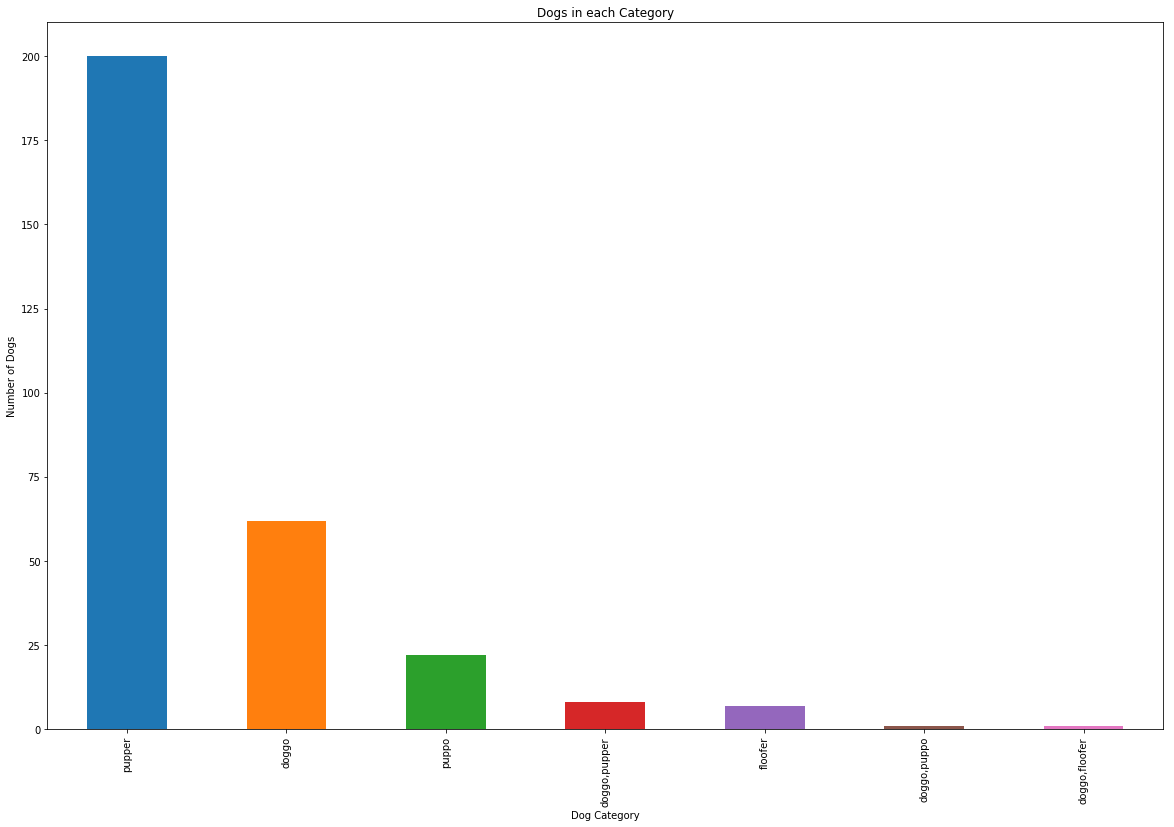

In [121]:
plt.figure(figsize = (20,13))
plt.title('Dogs in each Category')
plt.xlabel('Dog Category')
plt.ylabel('Number of Dogs')
master.dog_category.value_counts().plot(kind='bar');

Pupper is by far the most popular category of dog posted on the tweeter page. Doggo comes in second, with less that half as many in the category. Based off the chart, there are more dogs in the pupper category than all of the other dogs combined.

3. Average Rating for Categories

In [100]:
master.groupby(['dog_category']).mean().rating

dog_category
doggo            11.870968
doggo,floofer    11.000000
doggo,pupper     11.000000
doggo,puppo      13.000000
floofer          12.000000
pupper           10.635000
puppo            12.000000
Name: rating, dtype: float64

Though pupper's are the most common dog posted on the page, doggo_puppo’s average the highest ratings. This could be contributed to the fact that the last chart displays that there are very few dogs in this category. With fewer dogs in the category, the number could be skewed by one high review.

4. Retweets verse Favorites

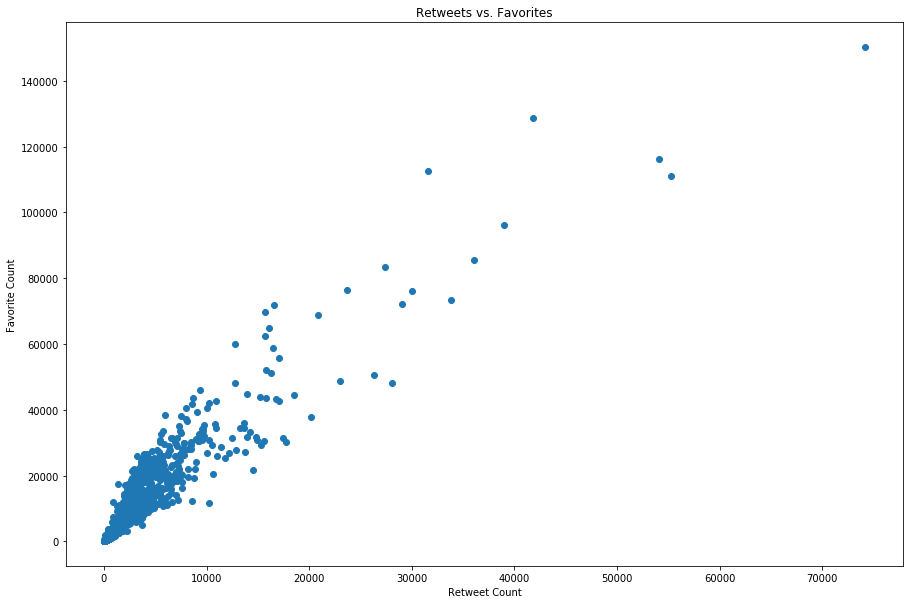

In [132]:
x = master.retweet_count
y = master.favorite_count
plt.figure(figsize=(15, 10))
plt.scatter(x, y)
plt.title('Retweets vs. Favorites')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.show();

When comparing the number of retweets a tweet has and the number for favorites, there seems to be a strong positive correlation between the two values. As the number of retweets rises, the number of favorites also rises in a linear fashion. This is consistent between all of the tweets displayed in the scatterplot.